In [304]:
%pylab inline
from sshtunnel import SSHTunnelForwarder
import pymongo
import os
import stat
import json
import datetime
import paramiko
import pandas
import seaborn as sns

pkey=os.path.join(os.environ['HOME'],'.ssh/id_rsa')
key=paramiko.RSAKey.from_private_key_file(pkey)

MONGO_HOST = "129.94.162.112"
MONGO_USER = "goios"
MONGO_DB = "modal-2duct-simulations"
#MONGO_COLLECTION = "modal-vt-bore-jumps-2"
MONGO_COLLECTION = "modal-vt-bore-many-pars"

local_port = 26017

# define ssh tunnel
with SSHTunnelForwarder(
    MONGO_HOST,
    ssh_username=MONGO_USER,
    ssh_pkey=key,
    remote_bind_address=('localhost', 27017),
    local_bind_address=('localhost',local_port)
) as server:
    connection = pymongo.MongoClient('localhost', local_port)
    db = connection[MONGO_DB]
    collection = db[MONGO_COLLECTION]
    
    connection.close()
    server.stop()

`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +



Populating the interactive namespace from numpy and matplotlib


In [305]:
from bson.objectid import ObjectId

with SSHTunnelForwarder(    
    MONGO_HOST,
    ssh_username=MONGO_USER,
    ssh_pkey="~/.ssh/id_rsa",
    remote_bind_address=('localhost', 27017),
    local_bind_address=('localhost',local_port)
) as server:
    with pymongo.MongoClient('localhost', local_port) as connection:
        db = connection[MONGO_DB]
        collection = db[MONGO_COLLECTION]
        print(collection.count())
        print(json.dumps(db.command("dbstats"),indent=2))
#         for d in collection.find():
#             err = "Ok"
#             try:
#                 d['simulation']['error']
#                 err='Error in simulation'
#             except KeyError:
#                 pass
#             try:
#                 d['analysis']['error']
#                 err='Error in analysis'
#             except KeyError:
#                 pass
                
#             print(d['_id'],d['simulation']['start'],d['simulation']['end'],err)
        #ll = list(collection.find({'simulation.params.gamma.sustain_val': {'$gt':.4, '$lt':.65}}))
        ll = list(collection.aggregate([ {'$match':{'simulation.params.gamma.sustain_val': {'$gt':.6, '$lt':.7}}}, { "$sample": { "size": 1 } } ]))
        #ll = list(collection.find().sort([('simulation.start',-1)]).limit(1))
        #ll = list(collection.find({'$where':'analysis.pert_time < analysis.t_trans_start'}).sort([('simulation.start',-1)]).limit(1))
#         ids = list(collection.aggregate( [{ '$project': { 
#                                               'eq': { '$cond': [ { '$lt': [ '$analysis.pert_time', '$analysis.t_trans_start' ] }, 1, 0 ] } 
#                                                      } },
#                                          { '$match': { 'eq' : 1 } }, 
#                                          { '$sort' : {'simulation.start': 1}},
#                                          { '$limit' : 1},
#                                          { "$group": {
#                                                         "_id": "$_id",
#                                                         "lastComment": { "$first": "$$CURRENT" }
#                                                     }
#                                                 },
#                                          { '$replaceRoot': { 'newRoot': '$lastComment' } }
#                                             ]))
        # An example with fvt near fbore with large ratio in transient, a burst
        #ll = list(collection.find({'_id':ObjectId('5f9bb9cf6842f0d613c43f20')}))
        ll = list(collection.find({'_id':ObjectId('5f9dabfc48f3045bca308c4b')}))
    print(len(ll))

  print(collection.count())



95087
{
  "db": "modal-2duct-simulations",
  "collections": 9,
  "views": 0,
  "objects": 310772,
  "avgObjSize": 5250.84915951244,
  "dataSize": 1631816895.0,
  "storageSize": 1012686848.0,
  "numExtents": 0,
  "indexes": 9,
  "indexSize": 5820416.0,
  "fsUsedSize": 27487686656.0,
  "fsTotalSize": 44780494848.0,
  "ok": 1.0
}
1


In [306]:
print(json.dumps(ll[0],indent=2,default=str))

{
  "_id": "5f9dabfc48f3045bca308c4b",
  "simulation": {
    "start": "2020-11-01 05:24:42.888000",
    "params": {
      "description": "Reed simulation with modal tracts and reed dynamics and non-linear reed force var gamma",
      "version": "20201026",
      "db": "modal-vt-bore-many-pars",
      "tmax": 0.5,
      "gamma": {
        "sustain_val": 0.7466724453492051,
        "time_const": 0.05,
        "exp_limit_multiplier": 1.1
      },
      "zeta": 0.2728923633502846,
      "reed": {
        "frequency": 2300.6423627847917,
        "q": 4.413572061014909,
        "amplitude": 4.413572061014909
      },
      "bore": {
        "frequencies": [
          755.9439438331804
        ],
        "qs": [
          28.58153430623993
        ],
        "amplitudes": [
          28.58153430623993
        ]
      },
      "vocal": {
        "frequencies": [
          616.7584398464255
        ],
        "qs": [
          8.260165383974662
        ],
        "amplitudes": [
          8.260

In [307]:
from random_single_mode_vt_bore_reed import ivp_simulate, do_analysis, nl_from_js

def simulate_js(js):
    data,cs = ivp_simulate(js,return_obj=True)
    analysis = do_analysis(data, impedance=False)
 
    return data,analysis,cs

In [308]:
from scipy.optimize import fmin

from functools import partial

def resonance(x,f=100,q=10,a=1):
    omegar=2*pi*f
    s = 1j*x*2*pi
    #fs = (a*omegar*q)**0*s**0/(s**2+s*omegar/q+omegar**2)
    fs = a*omegar/q*s/(s**2+s*omegar/q+omegar**2)
    return(np.abs(fs))

def impedance(x, fvec, qvec, avec):
    ret = 0*x
    for f, q, a in zip(fvec,qvec,avec):
        ret += resonance(x, f, q, a)
    return ret

fsrch = lambda x: -impedance(x, fvec, qvec, avec)

def impedance_info(row):
    zbore = partial(resonance,f=row['simulation/params/bore/frequencies/0'],
                              q=row['simulation/params/bore/qs/0'],
                              a=row['simulation/params/bore/amplitudes/0'])
    zvt = partial(resonance,f=row['simulation/params/vocal/frequencies/0'],
                              q=row['simulation/params/vocal/qs/0'],
                              a=row['simulation/params/vocal/amplitudes/0'])
    ztotal = lambda x: zbore(x)+zvt(x)
    zrat = lambda x: zbore(x)/zvt(x)
    zbore_max_f = fmin(lambda x: -zbore(x),row['simulation/params/bore/frequencies/0'],disp=False)[0]
    zbore_max = zbore(row['analysis/f0'])
    zrat_f0 = zrat(row['analysis/f0'])
    return pandas.Series({"zb_max_f":zbore_max_f,"zb_max_val":zbore_max,"zrat_f0":zrat_f0})



In [309]:
from json_object import JSONObject
row = JSONObject(ll[0])

In [310]:
import os
import numpy as np
from glob import glob
from pypevoc.Heterodyne import HeterodyneHarmonic
from pypevoc.PVAnalysis import PV
import timeseries as ts
import scipy.signal as sig

def db(x):
    return 20*np.log10(x)



In [8]:
jso = JSONObject(ll[0]['simulation']['params'])
#jso['bore/frequencies/0']=jso['vocal/frequencies/0']
#jso['bore/frequencies/0']=jso['vocal/frequencies/0']*.9

In [360]:
jso = JSONObject({
    "description": "Reed simulation with modal tracts and reed dynamics and non-linear reed force var gamma",
    "version": "20201026",
    "db": "modal-vt-bore-jumps-2",
    "tmax": 0.5,
    "gamma": {
      "sustain_val": 0.5,
      "time_const": 0.05,
      "exp_limit_multiplier": 1.1
    },
    "zeta": 0.4,
    "reed": {
      "frequency": 4600.,
      "q": 1.,
      "amplitude": 1.
    },
    "bore": {
      "frequencies": [
        350
      ],
      "qs": [
        25
      ],
      "amplitudes": [
        25
      ]
    },
    "vocal": {
      "frequencies": [
        500
      ],
      "qs": [
        10
      ],
      "amplitudes": [
        10
      ]
    },
    "nlfunc": None, 
#     {
#       "type": "parabolic",
#       "nl_start": 0.75,
#       "nl_ev": 1.1
#     },
    "perturbation": {
      "multiplier": 1.1,
      "duration": 1.8322260041225413
    },
    "simulation": {
      "sample rate": 97685.21184818557
    }
  })

In [361]:
import random
from json_object import JSONObject

#row = df[np.abs(-20*np.log10(df['zrat_f0'])-df['analysis/hrat1_abs_fin'])>5].sample().iloc[0]
#row = df[df['analysis/hrat1_abs_fin']<-20].sample().iloc[0]
# row = df1[df1['analysis/hrat1_abs_trans']-df1['analysis/hrat1_abs_fin']<-10].sample().iloc[0]
#row = df1.sample().iloc[0]
idx= 0
data,anal,cs=simulate_js(jso)

None


  frat = fx / self.oldfft

  frat = fx / self.oldfft



4096.0
4096.0
4468.363636363636
4468.363636363636
4096.000000000001
4096.0
4096.0
4096.0
4096.0
4468.363636363636
4468.363636363636
4096.000000000001
4096.0
4096.0


In [362]:
js = jso

jsg = js['gamma']
gamma = jsg['sustain_val']
tau = jsg['time_const']
gamma_lim_mult= jsg['exp_limit_multiplier']

zeta = js['zeta']

jsr = js['reed']
fr = jsr['frequency']
qr = jsr['q']
ar = jsr['amplitude']

jsb = js['bore']             
fac = np.array(jsb['frequencies'].to_python())
qac = np.array(jsb['qs'].to_python())
aac = np.array(jsb['amplitudes'].to_python())

jsv = js['vocal']
fvt = np.array(jsv['frequencies'].to_python())
qvt = np.array(jsv['qs'].to_python())
avt = np.array(jsv['amplitudes'].to_python())

nlfunc = nl_from_js(js['nlfunc'])
print(nlfunc)
tmax = js['tmax']

jsp = js['perturbation']
pert_mult = jsp['multiplier'] 
pert_duration = jsp['duration']

gamma_lim = gamma*gamma_lim_mult
gamma_t = lambda t: (1-np.exp(-t/tau))*gamma_lim

import instr_vt_poleres as ivp

cs=ivp.croak_poleres(gamma=gamma_t,zeta=zeta,
                     fr=fr,qr=1,ar=1,
                     f1=fac,q1=qac,a1=aac,
                     fv=fvt,qv=qvt,av=avt,
                     nlfunc=nlfunc)

print(json.dumps(cs.acmode[0].__dict__,indent=2,default=str))
print(json.dumps(cs.__dict__,indent=2,default=str))

None
{
  "f": "350",
  "q": "25",
  "a": "25",
  "w": 2199.114857512855,
  "w2": 4836106.156533784,
  "s": "(-43.982297150257104+2198.6749905502566j)",
  "c": "(1099.5574287564275+21.99554812475247j)",
  "pc": 0,
  "p0": "0.00020004001200400143j"
}
{
  "gamma": "<function <lambda> at 0x1315095e0>",
  "zeta": 0.4,
  "fr": 4600.0,
  "fa": "[350]",
  "fv": "[500]",
  "qr": 1,
  "qa": "[25]",
  "qv": "[10]",
  "ar": 1,
  "aa": "[25]",
  "av": "[10]",
  "wr": 28902.652413026095,
  "wr2": 835363316.5082031,
  "wa": "[2199.11485751]",
  "wa2": "[4836106.15653378]",
  "sr": "(-14451.326206513048+25030.431226432203j)",
  "cr": "-16686.954150954803j",
  "acmode": [
    "<instr_vt_poleres.acoustic_mode_poleres object at 0x12e572eb0>"
  ],
  "nmodes": 1,
  "vtmode": [
    "<instr_vt_poleres.acoustic_mode_poleres object at 0x12e572460>"
  ],
  "wv": "[3141.59265359]",
  "wv2": "[9869604.40108936]",
  "nvtmodes": 1,
  "alpha": 0.001,
  "alpha2": 1e-06,
  "nlfunc": null,
  "eps": 1e-08,
  "dt": 2.173

In [363]:
data['zeta']

array([0.4       , 0.4       , 0.4       , ..., 0.40829815, 0.4082982 ,
       0.40829825])

(-0.015099919209723, 0.21159253465462743)

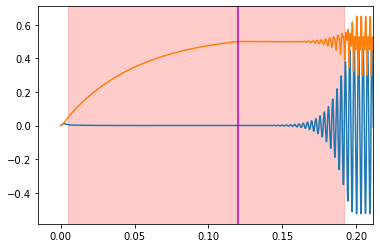

In [364]:
figure()
t = np.arange(len(data['p_b']))/data['js']['simulation']['sample rate']
plot(t,data['p_b'])
plot(t,data['p_vt']+data['p_blow'])
axvline(anal['pert_time'],color='m')
axvspan(anal['t_trans_start'],anal['t_trans_end'],color='r',alpha=.2)

marg = 0.02
xlim(anal['t_trans_start']-marg,anal['t_trans_end']+marg)

In [366]:
print(anal['b1_t_max'],anal['b1_abs_max'],anal['b1_abs_sus'],anal['b1_abs_fin'])
print(anal['vt1_t_max'],anal['vt1_abs_max'],anal['vt1_abs_sus'],anal['vt1_abs_fin'])

0.20173913043478997 0.5054933024840332 0.49505946786335614 0.49264573967289194
0.49001739130436595 0.0725398961222127 0.0718421230399565 0.07188408982656518


(0.09634499443686417, 0.17412098572227805)

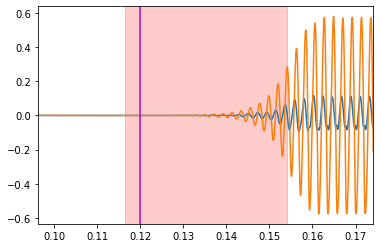

In [316]:
figure()
t = np.arange(len(data['p_b']))/data['js']['simulation']['sample rate']
plot(t,data['p_b'])
plot(t,data['p_vt'])
axvline(anal['pert_time'],color='m')
axvspan(anal['t_trans_start'],anal['t_trans_end'],color='r',alpha=.2)

marg = 0.02
xlim(anal['t_trans_start']-marg,anal['t_trans_end']+marg)

In [317]:
row['analysis/f0']

735.4889353093478

In [318]:
t_init=[0.01,0.05]
t_fin=0.1
tsust=0.1

# extract main parameters
res = {}
sr = data['js']['simulation']['sample rate']
pb = data['p_b']
pvt = data['p_vt']

zcb = jso['bore/amplitudes/0']

u = data['zeta']*(1+data['a'])*np.sqrt(np.abs((data['p_blow']+data['p_vt']-data['p_b'])))*np.sign(data['p_blow']+data['p_vt']-data['p_b'])

t = np.arange(len(pb))/sr
if data['pert_time']>0:
    res['pert_time']=data['pert_time']
else:
    res['pert_time'] = 0


pbinit = pb[int(t_init[0]*sr):int(t_init[1]*sr)]
res['initial amplitude'] = np.max(pbinit)-np.min(pbinit)
pbfin = pb[-int(t_fin*sr):]
res['final amplitude'] = np.max(pbfin)-np.min(pbfin) 

# fundamental frequency for harmonic analysis
pvpb = PV(pb,sr=sr,progress=False,nfft=1024*16,hop=512*2,pkthresh=1e-10)
pvpb.run_pv()
fts = ts.SampledTimeSeries(pvpb.fundamental_frequency, pvpb.t)

f0 = fts.percentile(50,from_time=fts.t[-1]-0.2)
if f0<20:
    f0 = np.median(fts.v[fts.v>0])
res['f0'] = f0
fw,pbw = sig.welch(pb,nperseg=2**10,nfft=2**12,fs=sr)

mainf = pvpb.f[np.arange(pvpb.f.shape[0]),np.argmin(np.abs(pvpb.f-f0),axis=1)]
mainfts = ts.SampledTimeSeries(mainf, pvpb.t)
mainfts.label = 'f0'

# harmonic analysis
try:
    nwind = int(sr/f0*3)
except ValueError:
    nwind = 1024


ha = {}
for lab in ('b', 'vt', 'm'):
    try:
        p = data['p_{}'.format(lab)]
    except KeyError:
        continue

    h = HeterodyneHarmonic(p,sr=sr,tf=[0,max(pvpb.t)],f=[f0,f0],nwind=nwind,nhop=128)
    h_array = [ts.SampledTimeSeries(np.abs(h.camp[:,ii]),h.t,label='h{}{}'.format(lab,ii+1)) for ii in range(h.camp.shape[1])]
    ha[lab] = h_array
    for ii, hts in enumerate(h_array):
        res['{}_t_min'.format(hts.label)]=hts.min_time()
        res['{}_t_max'.format(hts.label)]=hts.max_time()
        res['{}_abs_min'.format(hts.label)]=hts.min()
        res['{}_abs_max'.format(hts.label)]=hts.max()
        res['{}_abs_fin'.format(hts.label)]=hts.v[-1]
        if data['pert_time']>1e-4:
            res['{}_abs_pert'.format(hts.label)]=hts[data['pert_time']]
        else:
            res['{}_abs_pert'.format(hts.label)]=np.nan    

hts_array = ha['b']
vts_array = ha['vt']

# transient detection using one envelope
ats = hts_array[0]

amax = ats.max()

a_trans_end = amax*.7
a_trans_start = amax*.001
try:
    t_trans_end = ats.crossing_times(a_trans_end)[0][0]
except IndexError:
    t_trans_end = ats.v[-1]
try:
    t_trans_start = ats.crossing_times(a_trans_start,to_time=t_trans_end)[0][0]
except IndexError:
    t_trans_start = t_trans_end - ats.dt

atrans, ttrans = ats.apply(db).times_values_in_range(from_time=t_trans_start,to_time=t_trans_end)

# frequency comparison
fsusav = fts.mean(from_time=fts.t[-1]-tsust)
res['t_trans_start']=t_trans_start
res['t_trans_end']=t_trans_end
res['sus_f0_avg']=fts.mean(from_time=fts.t[-1]-tsust)
res['sus_f0_std']=fts.std(from_time=fts.t[-1]-tsust)
res['trans_f0_avg']=fts.mean(from_time=t_trans_start, to_time=t_trans_end)
res['trans_f0_std']=fts.std(from_time=t_trans_start, to_time=t_trans_end)

# harmonic descriptor extraction
for h_array in (hts_array,vts_array):
    for ii, hts in enumerate(h_array):
        res['{}_abs_sus'.format(hts.label)]=hts.percentile(50,from_time=fts.t[-1]-tsust)
        res['{}_abs_sus_var'.format(hts.label)]=np.diff(hts.percentile([75,25],from_time=fts.t[-1]-tsust))[0]
        res['{}_abs_trans'.format(hts.label)]=hts.percentile(50,from_time=t_trans_start, to_time=t_trans_end)
        res['{}_abs_trans_var'.format(hts.label)]=np.diff(hts.percentile([75,25],from_time=t_trans_start, to_time=t_trans_end))[0]

    # growth rate via derivative
    dts = hts.apply(db).diff()
    dts.label = hts.label
    for pct in [25,50,75]:
        res['{}_trans_rate_pct{}'.format(dts.label,pct)]=dts.percentile(pct,from_time=t_trans_start, to_time=t_trans_end)

    res['{}_abs_fin'.format(hts.label)]=hts.v[-1]
    if data['pert_time']>1e-4:
        res['{}_abs_pert'.format(hts.label)]=hts[data['pert_time']]
    else:
        res['{}_abs_pert'.format(hts.label)]=np.nan    

# harmonic ratio descriptors
for ii, hts in enumerate(hts_array):
    vts = vts_array[ii]
    rts = vts.apply(db)-hts.apply(db)
    rts.label = 'hrat{}'.format(ii+1)
    res['{}_abs_sus'.format(rts.label)]=rts.percentile(50,from_time=fts.t[-1]-tsust)
    res['{}_abs_sus_var'.format(rts.label)]=np.diff(rts.percentile([75,25],from_time=fts.t[-1]-tsust))[0]
    res['{}_abs_trans'.format(rts.label)]=rts.percentile(50,from_time=t_trans_start, to_time=t_trans_end)
    res['{}_abs_trans_var'.format(rts.label)]=np.diff(rts.percentile([75,25],from_time=t_trans_start, to_time=t_trans_end))[0]
    res['{}_abs_fin'.format(rts.label)]=rts.v[-1]
    if data['pert_time']>1e-4:
        res['{}_abs_pert'.format(rts.label)]=rts[data['pert_time']]
    else:
        res['{}_abs_pert'.format(rts.label)]=np.nan    



  frat = fx / self.oldfft

  frat = fx / self.oldfft



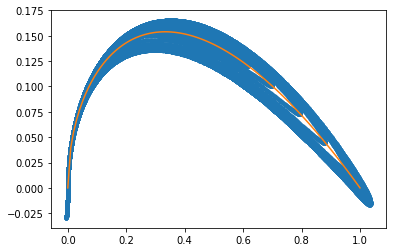

In [319]:
figure()
plot(data['p_blow']-data['p_b']+data['p_vt'],u,'.')
#plot(u)
#plot(data['a'])
dpt = np.linspace(0,1.0,100)
if cs.nlfunc:
    a = cs.nlfunc(dpt)
else:
    a = 1-dpt
ut = cs.zeta*np.sqrt(dpt)*a
plot(dpt,ut)

In [320]:
from pypevoc.Heterodyne import heterodyne

def heterodyne_corr(x,sr,f,maxwind=2**14,nhop=2**10,nper=3,dc_cut=50, release_partials=True):
    #c1,_ = heterodyne(x,x,wind=np.hanning(nwind),hop=nhop)
    xx = x.copy()
#     newn = int(len(xx)/sr*dc_cut)
#     x2 = np.concatenate((xx,np.zeros(int((newn+1)*sr/dc_cut))))
#     print(newn,x2.shape)
#     xd = sig.resample(x2,newn)
#     xu = sig.resample(xd,len(x2))[:len(xx)]
#     xx -= xu
    t = np.arange(len(x))/sr
    #npts = len(c1)
    nharm = len(f)
    #camp = np.zeros((npts,nharm),dtype='complex')
    ret = []
    part = np.zeros((len(x),nharm))
    for ii,ff in enumerate(f):
        #nwind = int(min(maxwind,sr/ff*nper))
        if ff==0.:
            nwind=maxwind
        foth = np.delete(f,ii)
        nwind = (sr/np.min(np.abs(foth-ff))*nper)
        print(nwind)
        hetsig = np.exp(1j*2*np.pi*ff*t)
        if release_partials:
            cc,ih = heterodyne(xx,hetsig,wind=np.hanning(nwind),hop=nhop)
        else:
            cc,ih = heterodyne(x,hetsig,wind=np.hanning(nwind),hop=nhop)
        if ff==0.:
            cc/=2
        th=ih/sr
        ret.append(ts.SampledTimeSeries(cc,th,label='%.2f'%ff))
        ret[-1].f = ff
        hf = np.interp(t,th,cc)
        xp = np.real(np.conjugate(hf)*hetsig)
        xx-=xp
        part[:,ii]=xp
    return ret,xx,part

def heterodyne_freq_corr(hh,f):
    return hh.v

[   0.          449.21875     926.51367187 1375.73242187 1853.02734375]
3072.0
3072.0
3072.000000000001
3072.000000000001
2891.2941176470586
3072.0
3072.0
3072.000000000001
3072.000000000001
2891.2941176470586
3072.0
3072.0
3072.000000000001
3072.000000000001
2891.2941176470586


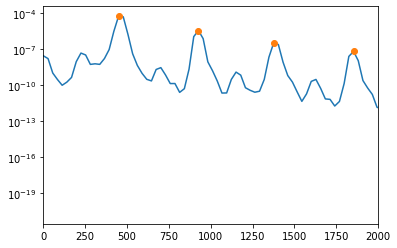

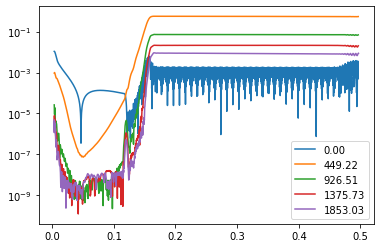

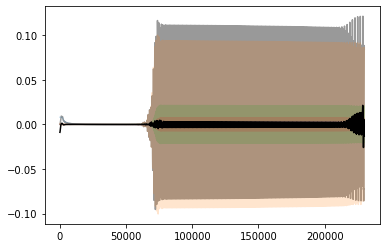

In [321]:
from scipy.signal import welch,find_peaks

fw,w=welch(pb,fs=sr,nperseg=2**14)

fig,ax=subplots(1)
semilogy(fw,w)
xlim(0,2000)

pks,_=find_peaks(10*np.log10(w),prominence=20)
ff=fw[pks]
ff=ff[(ff<2000)&(ff>100)]
nw=int(sr/np.min(ff)*6)
semilogy(fw[pks],w[pks],'o')

ff=np.insert(ff,0,0)

print(ff)

#nw=nwind
nw=2**16
nper=3
release_partials=True
hetpb,pbresid,pbpart=heterodyne_corr(pb,sr,ff,maxwind=nw,nhop=128,nper=nper,release_partials=release_partials)
hetpv,pvresid,pvpart=heterodyne_corr(pvt,sr,ff,maxwind=nw,nhop=128,nper=nper,release_partials=release_partials)
hetu,uresid,upart = heterodyne_corr(u,sr,ff,maxwind=nw,nhop=128,nper=nper,release_partials=release_partials)
fig,ax=subplots(1)
for tts in hetpv:
    ax.semilogy(tts.t,np.abs(tts.v),label=tts.label)
    
ax.legend()
ax.set_yscale('log')

figure()
plot(pb,color='k',alpha=.4)
plot(pbpart,alpha=.2)
plot(pbresid,color='k')

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12bb35e50>)

<Figure size 432x288 with 0 Axes>

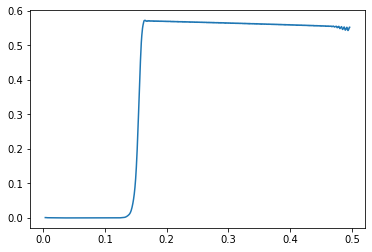

In [359]:
figure()
hetpv[1].apply(abs).plot()

(-4.0, 4.0)

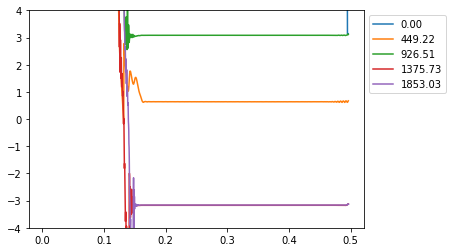

In [322]:
fig,ax=subplots(1)

def safe_angle(x):
#     x1 = np.angle(x)
#     x2 = np.angle(-x)
#     if np.std(x1)<np.std(x2):
#         return x1
#     else:
#         return x2+pi
    return np.mod(np.unwrap(np.angle(x)+pi),2*pi)-pi

for tsv,tsb in zip(hetpv,hetpb):
    tts=(tsv/tsb).apply(lambda x:np.flipud(np.unwrap(np.angle(np.flipud(x)))))
    tts.label=tsv.label
    tts.plot(ax=ax)
    
ax.legend(bbox_to_anchor=(1,1),loc='upper left')
ax.set_ylim(-4,4)

In [323]:
thr=.05
f0r = f0
for f in ff:
    if f==0:
        continue
    frat = f/f0r
    hno = np.round(frat)
    fdev = np.abs(frat-hno)
    print(f,frat,fdev,fdev<thr,hno)
    #if fdev<thr:
    #    f0r=np.mean([f0r,f/hno])
    

449.21874999999994 0.9719855100384136 0.028014489961586397 True 1.0
926.5136718749999 2.004720114454228 0.004720114454228153 True 2.0
1375.7324218749998 2.9767056244926415 0.023294375507358467 True 3.0
1853.0273437499998 4.009440228908456 0.009440228908456305 True 4.0


In [324]:
np.diff(fw)[0]

28.076171874999996

In [325]:
f0r

462.16609749897043

(0.09634499443686417, 0.17412098572227805)

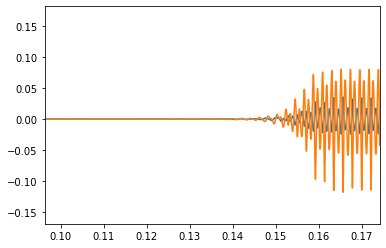

In [326]:
def semilogabsy(x,y,*args,**kwargs):
    return semilogy(x,np.abs(y),*args,**kwargs)
figure()
plot(np.arange(len(pb))/sr,pb-np.sum(pbpart[:,0:2],axis=1))
plot(np.arange(len(pb))/sr,pvt-np.sum(pvpart[:,0:2],axis=1))
marg = 0.02
xlim(anal['t_trans_start']-marg,anal['t_trans_end']+marg)

462.16609749897043 449.21874999999994
0.16083478260870154 0.10078447633306063
0.056208695652175886 8.443776726644174e-07
0.1652869565217452 0.5723507514868367
0.0503652173913061 7.341708845584861e-08


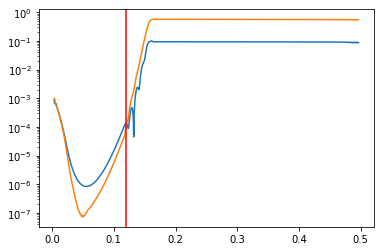

In [327]:
mainidx = np.argmin(np.abs(np.array(ff)-f0))
print( f0,ff[mainidx])
fig,ax=subplots(1)
plot(hetpb[mainidx].t,np.abs(hetpb[mainidx].v))
habs = hetpb[mainidx].apply(abs)
print (habs.max_time(),habs.max())
print (habs.min_time(),habs.min())
plot(hetpv[mainidx].t,np.abs(hetpv[mainidx].v))
habs = hetpv[mainidx].apply(abs)
print (habs.max_time(),habs.max())
print (habs.min_time(),habs.min())
ax.set_yscale('log')
ax.axvline(data['pert_time'],color='r')

In [328]:
pvt

array([-1.37891753e-05, -3.24087186e-05, -5.22643994e-05, ...,
        4.82006145e-01,  4.83803542e-01,  4.85587477e-01])

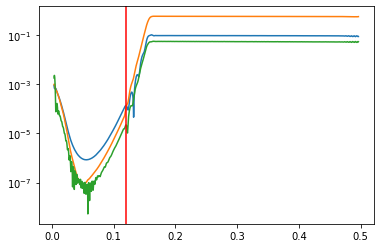

In [329]:
fig,ax=subplots(1)
hb = hetpb[mainidx].apply(np.abs)
hb.label = hetpb[mainidx].label
hb.plot(ax=ax)
hv = hetpv[mainidx].apply(np.abs)
hv.label = hetpv[mainidx].label
hv.plot(ax=ax)
hu = hetu[mainidx].apply(np.abs)
hu.label = hetu[mainidx].label
hu.plot(ax=ax)

ax.axvline(data['pert_time'],color='r')
ax.set_yscale('log')

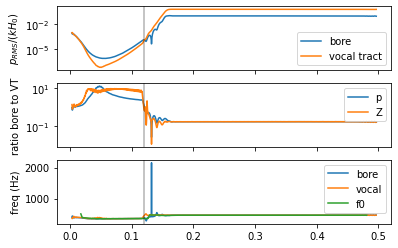

In [330]:

hh = hetpb[mainidx]
fbc=(hh.apply(np.angle).apply(np.unwrap).diff()/2/pi).apply(lambda x: hh.f-x)
fbc.label = 'bore'
hh = hetpv[mainidx]
fvc=(hh.apply(np.angle).apply(np.unwrap).diff()/2/pi).apply(lambda x: hh.f-x)
fvc.label = 'vocal'


fig,ax = plt.subplots(3,sharex=True)
hb1 = hb.copy()
hb1.f = float(hb.label)
hb1.label= 'bore'
hb1.plot(ax=ax[0])
hv1 = hv.copy()
hv1.f = float(hv.label)
hv1.label='vocal tract'
hv1.plot(ax=ax[0])
ax[0].set_yscale('log')
ax[0].set_ylabel('$p_{RMS}/(k H_0)$')
ax[0].legend()
(hb1/hv1).plot(ax=ax[1])
ax[1].set_yscale('log')
ax[1].set_ylabel('ratio bore to VT')
# zts = mainfts.apply(lambda x: impedance(x,fvec = [row['simulation/params/bore/frequencies/0']],
#          qvec = [row['simulation/params/bore/qs/0']],
#          avec=[row['simulation/params/bore/amplitudes/0']])/impedance(x,fvec = [row['simulation/params/vocal/frequencies/0']],
#          qvec = [row['simulation/params/vocal/qs/0']],
#          avec=[row['simulation/params/vocal/amplitudes/0']]))
zb =  fbc.apply(lambda x: impedance(x,fvec = [jso['bore/frequencies/0']],
          qvec = [jso['bore/qs/0']],
          avec=[jso['bore/amplitudes/0']]))
zv =  fvc.apply(lambda x: impedance(x,fvec = [jso['vocal/frequencies/0']],
          qvec = [jso['vocal/qs/0']],
          avec=[jso['vocal/amplitudes/0']]))
zts = zb/zv
zts.plot(ax=ax[1])
ax[1].legend(['p','Z'])


ax[2].set_ylabel('freq (Hz)')
fbc.plot(ax=ax[2])
fvc.plot(ax=ax[2])

mainfts.plot(ax=ax[2])

for axi in ax:
    axi.axvline(data['pert_time'],color='k',alpha=.3)
#ax[2].set_ylim(300,400)
ax[2].legend()

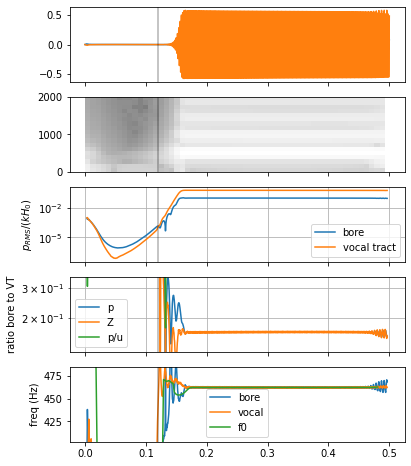

In [331]:

hh = hetpb[mainidx]
fbc=(hh.apply(np.angle).apply(np.unwrap).diff()/2/pi).apply(lambda x: hh.f-x)
fbc.label = 'bore'
hh = hetpv[mainidx]
fvc=(hh.apply(np.angle).apply(np.unwrap).diff()/2/pi).apply(lambda x: hh.f-x)
fvc.label = 'vocal'


fig,ax = plt.subplots(5,sharex=True,figsize=(6,8))

ax[0].plot(np.arange(len(data['p_b']))/sr,data['p_b'])
ax[0].plot(np.arange(len(data['p_vt']))/sr,data['p_vt'])

ax[1].specgram(data['p_b'],NFFT=2**12,Fs=sr,cmap='gray')
ax[1].set_ylim(0,2000)

hb1 = hb.copy()
hb1.f = float(hb.label)
hb1.label= 'bore'
hb1.plot(ax=ax[2])
hv1 = hv.copy()
hv1.f = float(hv.label)
hv1.label='vocal tract'
hv1.plot(ax=ax[2])
ax[2].set_yscale('log')
ax[2].set_ylabel('$p_{RMS}/(k H_0)$')
ax[2].legend()
hrat = hb1/hv1
hrat.plot(ax=ax[3])

range_time_from = res['t_trans_start']

pmax = hrat.percentile(95,from_time=range_time_from)
pmin = hrat.percentile(5,from_time=range_time_from)
prange = pmax/pmin
range_marg=.5
ax[3].set_ylim(pmin/prange**range_marg,pmax*prange**range_marg)
ax[2].grid(True)

ax[3].set_yscale('log')
ax[3].set_ylabel('ratio bore to VT')
# zts = mainfts.apply(lambda x: impedance(x,fvec = [row['simulation/params/bore/frequencies/0']],
#          qvec = [row['simulation/params/bore/qs/0']],
#          avec=[row['simulation/params/bore/amplitudes/0']])/impedance(x,fvec = [row['simulation/params/vocal/frequencies/0']],
#          qvec = [row['simulation/params/vocal/qs/0']],
#          avec=[row['simulation/params/vocal/amplitudes/0']]))
zb =  fbc.apply(lambda x: impedance(x,fvec = [jso['bore/frequencies/0']],
          qvec = [jso['bore/qs/0']],
          avec=[jso['bore/amplitudes/0']]))
zv =  fvc.apply(lambda x: impedance(x,fvec = [jso['vocal/frequencies/0']],
          qvec = [jso['vocal/qs/0']],
          avec=[jso['vocal/amplitudes/0']]))
zts = zb/zv
zts.plot(ax=ax[3])
hdpu = hb/hu
hdpu.plot(ax=ax[3])

ax[3].legend(['p','Z','p/u'])
ax[3].grid(True,which='both')


ax[4].set_ylabel('freq (Hz)')
fbc.plot(ax=ax[4])
fvc.plot(ax=ax[4])

pmax = fbc.percentile(95,from_time=range_time_from)
pmin = fbc.percentile(5,from_time=range_time_from)
prange = pmax-pmin
range_marg=.5
ax[4].set_ylim(pmin-prange*range_marg,pmax+prange*range_marg)


mainfts.plot(ax=ax[4])

for axi in ax:
    axi.axvline(data['pert_time'],color='k',alpha=.3)
#ax[2].set_ylim(300,400)
ax[4].legend()

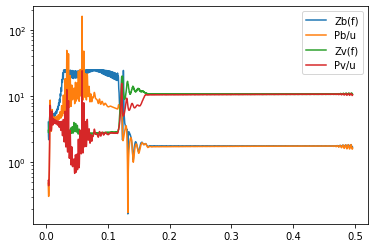

In [332]:
fig,ax = subplots(1)
(zb).plot(ax=ax)
zc=1
(hb/hu*zc).plot(ax=ax)
(zv).plot(ax=ax)
(hv/hu*zc).plot(ax=ax)
ax.set_yscale('log')
ax.legend(['Zb(f)','Pb/u','Zv(f)','Pv/u'])

In [333]:
zcb

25

In [334]:
t0=.2
hb.percentile(50,from_time=t0)/hu.percentile(50,from_time=t0)/zb.percentile(50,from_time=t0)

0.9890968692639074

In [335]:
t0=.2
hv.percentile(50,from_time=t0)/hu.percentile(50,from_time=t0)/zv.percentile(50,from_time=t0)

0.9876795197329112

  mag = 20*np.log10(self.mag)



(0.0, 2000.0)

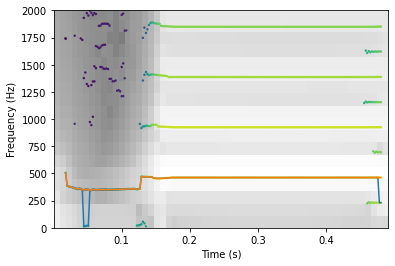

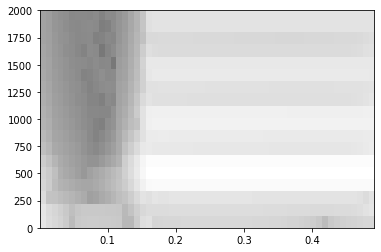

In [336]:
fig,ax = subplots(1)
ax.specgram(data['p_b'],Fs=sr,NFFT=2**12,cmap='gray')
pvpb.plot_time_freq(ax=ax)
ax.plot(pvpb.t,pvpb.fundamental_frequency)
ax.plot(pvpb.t,mainf)
ax.set_ylim(0,2000)
fig,ax = subplots(1)
ax.specgram(data['p_vt'],Fs=sr,NFFT=2**12,cmap='gray')
#pvpb.plot_time_freq(ax=ax)
# ax.plot(pvpb.t,pvpb.fundamental_frequency)
# ax.plot(pvpb.t,mainf)
ax.set_ylim(0,2000)

bore
449.22
0.13352148215801798 0.15241154515869088
-313.29802594502297 1876.6161143158397
0.13217391304348308 21.617170585269292
vocal tract
449.22
0.13384493302931694 0.1540909474795278
-315.41976203106714 1980.4742630491507
0.12326956521739578 3.2825493643917554


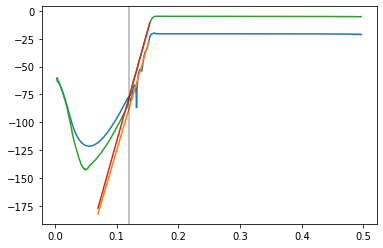

In [337]:
from sklearn.linear_model import RANSACRegressor
fig,ax=subplots(1)
rates = {}
for hh in [hb1,hv1]:
    print(hh.label)
    print(hh.f)
    hbl1=hh.apply(db)
    vals=hbl1.percentile([5,99])
    ted=hbl1.crossing_times(vals[1]-6)[0][0]
    tst=hbl1.crossing_times(vals[1]-46,to_time=ted)[0][-1]
    print(tst,ted)
    x,y=hbl1.times_values_in_range(tst,ted)
    X = np.array([x]).T
    rm=RANSACRegressor().fit(X,y)
    print(rm.estimator_.intercept_,rm.estimator_.coef_[0])
    rates[hh.label] = rm.estimator_.coef_[0]
    fig,ax=hbl1.plot(ax=ax)
    xpred,ytrue = hbl1.times_values_in_range(min(data['pert_time']-.05,tst),ted)
    if len(xpred)>0:
        Xpred = np.array([xpred]).T
        ypred = rm.predict(Xpred)
        ax.plot(xpred,ypred)
        print (xpred[np.argmax(ypred-ytrue)],np.max(ypred-ytrue))
    else:
        xpred=x
        Xpred = X
        ypred = rm.predict(Xpred)
        ax.plot(xpred,ypred)
ax.axvline(data['pert_time'],color='k',alpha=.3)
#ax.set_xlim(0,max(data['pert_time'],ted))
#ax.set_xlim(tst-(ted-tst),ted)

In [345]:
from scipy.optimize import fmin,minimize,fsolve

from functools import partial

def resonance(x,f=100,q=10,a=1):
    omegar=2*pi*f
    s = x#1j*x*2*pi
    fs = a*omegar*s/q/(s**2+s*omegar/q+omegar**2)
    return(fs)

def reed_resonance(x,f=100,q=10,a=1):
    omegar=2*pi*f
    s = x# 1j*x*2*pi
    fs = a*omegar**2/q/(s**2+s*omegar/q+omegar**2)
    #fs = omegar**2/(s**2+s*omegar/q+omegar**2)
    return(fs)

def resonance_pres(s,s0=1,c0=1):
    fs =  c0/(s-s0)
    return(fs)

def impedance(x, fvec, qvec, avec):
    ret = 0*x
    for f, q, a in zip(fvec,qvec,avec):
        ret += resonance(x, f, q, a)
    return ret

fsrch = lambda x: -impedance(x, fvec, qvec, avec)

dbps_to_alpha_fact = log(10)/20

zbore = partial(resonance,f=jso['bore/frequencies/0'],
                          q=jso['bore/qs/0'],
                          a=jso['bore/amplitudes/0'])
zvt = partial(resonance,f=jso['vocal/frequencies/0'],
                          q=jso['vocal/qs/0'],
                          a=jso['vocal/amplitudes/0'])
zkreed = partial(reed_resonance,f=jso['reed/frequency'],
                          q=jso['reed/q'],
                          a=jso['reed/amplitude'])

# zbore = partial(resonance_pres,s0=cs.acmode[0].s,
#                           c0=cs.acmode[0].c)
# zvt = partial(resonance_pres,s0=cs.vtmode[0].s,
#                           c0=cs.vtmode[0].c)
# zkreed = partial(resonance_pres,s0=cs.sr,
#                           c0=cs.cr)

zac = lambda x: (zbore(x)+zvt(x))

zcomb = lambda x: zac(x)*zkreed(x)

ist = int(min(data['pert_time'],res['t_trans_start'])*sr)
iend = int(res['t_trans_end']*sr)
zeta = np.mean(data['zeta'][ist:iend])
gamma = np.mean(data['p_blow'][ist:iend])
print(f'zeta = {zeta}, gamma ={gamma}')
chder = zeta*(np.sqrt(gamma)-1/2*(1-gamma))
print(f'p/u derivative: {chder}')

#eqc = lambda x: zcomb(x)
sqrg = np.sqrt(gamma)
eqc = lambda x: zeta*((-1/2/sqrg*(1-gamma)+sqrg*zkreed(x))*(zac(x)))#-sqrg*gamma)
alpha=cs.alpha
#eqc = lambda x: (zeta*(np.sqrt(np.abs(gamma)+alpha**2)-alpha)-zeta/2*(1-gamma)/np.sqrt(np.abs(gamma+alpha**2)))*(zac(x))

eq = lambda x: np.array([np.real(eqc(x[0]+1j*x[1]))-1, np.imag(eqc(x[0]+1j*x[1]))])
#eqc = lambda x:1/zac(x)
#eq = lambda x: np.array([np.real(eqc(x[0]+1j*x[1])), np.imag(eqc(x[0]+1j*x[1]))])

q = jso['vocal/qs/0']
x0v = 2*np.pi*jso['vocal/frequencies/0']*np.array([0,1])
s0v=fsolve(eq,x0v)
print(f'Measured f: trans = {res["trans_f0_avg"]}, sus = {res["sus_f0_avg"]}')
print(f'Measured rates: {rates["bore"]}, {rates["vocal tract"]}')
print("\nVocal tract solution:")
print(s0v)
print(f'rate = {s0v[0]/dbps_to_alpha_fact} dB/s\nf = {s0v[1]/2/np.pi} Hz')
q = jso['bore/qs/0']
x0b = 2*np.pi*jso['bore/frequencies/0']*np.array([0,1])
s0b=fsolve(eq,x0b)
print("--> errors:")
print("    in freq: "+str((s0v[1]/2/np.pi-res["trans_f0_avg"])/res["trans_f0_avg"]))
print("    in rate: "+str((s0v[0]/dbps_to_alpha_fact-rates["bore"])/rates["bore"]))
print("\nBore solution:")
print(s0b)
print(f'rate = {s0b[0]/dbps_to_alpha_fact} dB/s\nf = {s0b[1]/2/np.pi} Hz')
if np.abs(s0b[1]/2/np.pi-res["trans_f0_avg"])<np.abs(s0v[1]/2/np.pi-res["trans_f0_avg"]):
    s0=s0b
else:
    s0=s0v
print("--> errors:")
print("    in freq: "+str((s0b[1]/2/np.pi-res["trans_f0_avg"])/res["trans_f0_avg"]))
print("    in rate: "+str((s0b[0]/dbps_to_alpha_fact-rates["bore"])/rates["bore"]))

print("\nHarmonic ratio in transient")
print(f"  meas.: {res['hrat1_abs_trans']}")
print(f"  calc.: {20*np.log10(np.abs(zvt(s0[0]+1j*s0[1])/zbore(s0[0]+1j*s0[1])))}")

zeta = 0.40034473349379646, gamma =0.4994538910646282
p/u derivative: 0.18273633828407532
Measured f: trans = 428.66149822018843, sus = 452.1590139517708
Measured rates: 1876.6161143158397, 1980.4742630491507

Vocal tract solution:
[ 233.70897815 2950.77320427]
rate = 2029.9703916655558 dB/s
f = 469.63014140316216 Hz
--> errors:
    in freq: 0.09557341481116544
    in rate: 0.08171851247564538

Bore solution:
[ 127.13092424 2238.46459312]
rate = 1104.2451775372085 dB/s
f = 356.2627049308436 Hz
--> errors:
    in freq: -0.16889502227269337
    in rate: -0.4115764171939957

Harmonic ratio in transient
  meas.: 11.501002480663843
  calc.: 13.005672313283412


In [346]:
def cplot3(f,relim=[-5,5],imlim=[-5,5],points=2000,crange=None,levels=10,fontsize=10,ax=None,fmt='%1.2f',log=False):
    reb = relim[1]
    rea = relim[0]
    imb = imlim[1]
    ima = imlim[0]
    dre = reb - rea
    dim = imb - ima
    M = int(sqrt(points*dre/dim)+1)
    N = int(sqrt(points*dim/dre)+1)
    
    if crange is not None:
        vmin,vmax=crange
        if log:
            levels = np.logspace(np.log10(vmin),np.log10(vmax),levels+1)
        else:
            levels = np.linspace(vmin,vmax,levels+1)
    else:
        vmin=vmax=None

    x = np.arange(relim[0], relim[1], dre/M)
    y = np.arange(imlim[0], imlim[1], dim/N)
    X, Y = np.meshgrid(x, y)
    Z = f(X+Y*1j)
    if ax is None:
        fig, ax = plt.subplots()
    
    CSre = ax.contour(X, Y, real(Z),cmap='Blues',vmin=vmin,vmax=vmax,levels=levels)
    ax.clabel(CSre, inline=1, fontsize=fontsize,fmt=fmt)
    CSim = ax.contour(X, Y, imag(Z),cmap='Reds',vmin=vmin,vmax=vmax,levels=levels)
    ax.clabel(CSim, inline=1, fontsize=fontsize,fmt=fmt)
    ax.set_facecolor('black')
    ax.axvline(0,color='white',alpha=.2)
    return ax


def dplot3(f,relim=[-5,5],imlim=[-5,5],points=2000,crange=None,levels=10,fontsize=10,ax=None,fmt='%1.2f',log=False):
    reb = relim[1]
    rea = relim[0]
    imb = imlim[1]
    ima = imlim[0]
    dre = reb - rea
    dim = imb - ima
    M = int(sqrt(points*dre/dim)+1)
    N = int(sqrt(points*dim/dre)+1)
    
    if crange is not None:
        vmin,vmax=crange
    else:
        vmin=vmax=None

    x = np.arange(relim[0], relim[1], dre/M)
    y = np.arange(imlim[0], imlim[1], dim/N)
    X, Y = np.meshgrid(x, y)
    Z = f(X+Y*1j)
    if ax is None:
        fig, ax = plt.subplots()

    ax.imshow(Z,aspect='auto',origin='bottom',extent=[relim[0],relim[1],imlim[0],imlim[1]],cmap='viridis',vmin=vmin,vmax=vmax)
    ax.axvline(0,color='white',alpha=.2)
    return ax


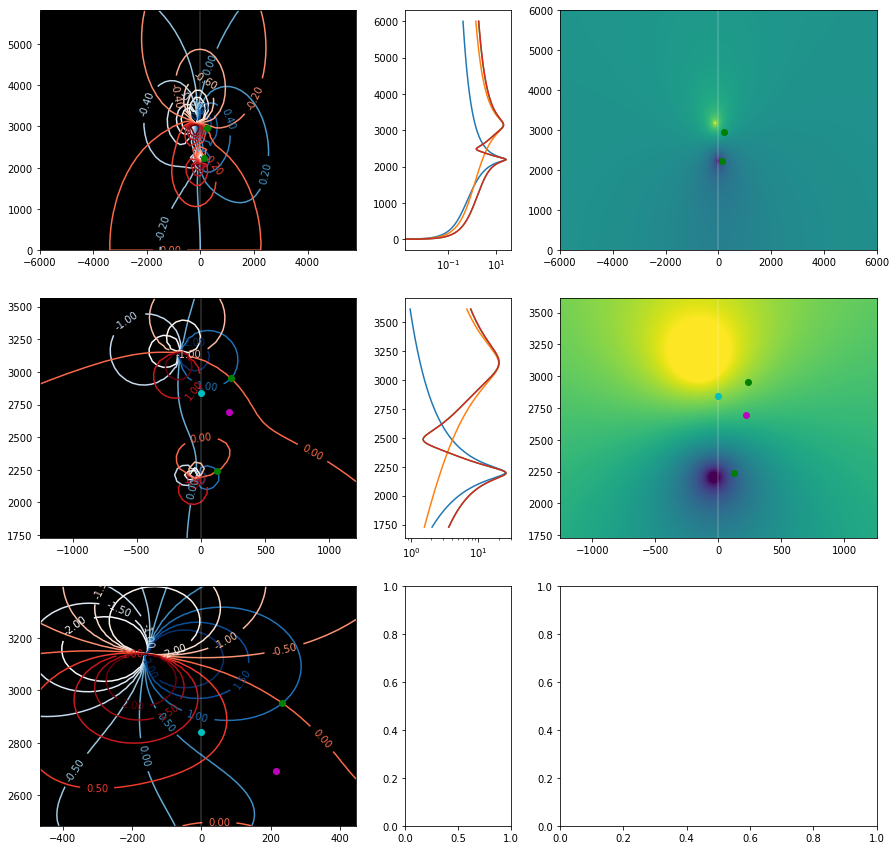

In [347]:
# measured s
sm = rates["bore"]*dbps_to_alpha_fact+1j*res["trans_f0_avg"]*2*pi

#vsol=1/chder
vsol = 1
widths = [3,1,1]
heights=[1,1,1]
fig,ax = plt.subplots(ncols=3,nrows=3,gridspec_kw=dict(width_ratios=[3,1,3],height_ratios=[1,1,1]),figsize=(15,15))

wlims = [0,6000]
cplot3(eqc,relim=[-6000,6000],imlim=wlims,crange=[-vsol,vsol],ax=ax[0,0])
dplot3(lambda x: 20*np.log10(np.abs(zvt(x)/zbore(x))),relim=[-6000,6000],imlim=wlims,ax=ax[0,2],points=20000)
for axi in [ax[0,0],ax[0,2]]:
    axi.plot(s0b[0],s0b[1],'og')
    axi.plot(s0v[0],s0v[1],'og')
wrange=np.linspace(wlims[0],wlims[1],1000)
ax[0,1].semilogx(np.abs(zbore(1j*wrange)),wrange)
ax[0,1].semilogx(np.abs(zvt(1j*wrange)),wrange)
ax[0,1].semilogx(np.abs(zbore(1j*wrange)+zvt(1j*wrange)),wrange)
ax[0,1].semilogx(np.abs(zcomb(1j*wrange)),wrange)
#ax=cplot3(eqc,imlim=x0[1]*np.array([.9,1.1]),relim=x0[1]*np.array([-.1,.1]),crange=[-1,1])
fv = js['vocal/frequencies/0']
fb = js['bore/frequencies/0']
qv = js['vocal/qs/0']
qb = js['bore/qs/0']
wmin = min(fv,fb,res['trans_f0_avg'])*2*pi
wmax = max(fv,fb,res['trans_f0_avg'])*2*pi
qmin = min(qv,qb)
wr = wmax-wmin
wlims = [wmin-wr/2,wmax+wr/2]
cplot3(eqc,imlim=wlims,relim=[-wmax/qmin*4,wmax/qmin*4],crange=[-2*vsol,2*vsol],levels=4,ax=ax[1,0])
dplot3(lambda x: 20*np.log10(np.abs(zvt(x)/zbore(x))),relim=[-wmax/qmin*4,wmax/qmin*4],imlim=wlims,ax=ax[1,2],points=20000,crange=[-20,20])
for axi in [ax[1,0],ax[1,2]]:
    #axi.plot(x0b[0],x0b[1],'oy')
    #axi.plot(x0v[0],x0v[1],'oy')
    axi.plot(s0b[0],s0b[1],'og')
    axi.plot(s0v[0],s0v[1],'og')
    axi.plot(sm.real,sm.imag,'om')
    axi.plot(0,2*pi*res["sus_f0_avg"],'oc')
wrange=np.linspace(wlims[0],wlims[1],1000)
ax[1,1].semilogx(np.abs(zbore(1j*wrange)),wrange)
ax[1,1].semilogx(np.abs(zvt(1j*wrange)),wrange)
ax[1,1].semilogx(np.abs(zbore(1j*wrange)+zvt(1j*wrange)),wrange)
ax[1,1].semilogx(np.abs(zcomb(1j*wrange)),wrange)

cplot3(eqc,relim=s0[0]*2*np.array([-1,1]),imlim=s0[1]+s0[0]*2*np.array([-1,1]),crange=[-2*vsol,2*vsol],levels=8,ax=ax[2,0])
ax[2,0].plot(s0[0],s0[1],'og')
ax[2,0].plot(sm.real,sm.imag,'om')
ax[2,0].plot(0,2*pi*res["sus_f0_avg"],'oc')

#fig.savefig('s-plane-{:%Y%m%d%H%M%S}.png'.format(datetime.datetime.now()))

In [344]:
def bodeplot(x,y,ax=None,**kwargs):
    if ax is None:
        _,ax= plt.subplots(2,sharex=True)
    ax[0].semilogy(x,np.abs(y),**kwargs)
    ax[1].plot(x,np.angle(y),**kwargs)

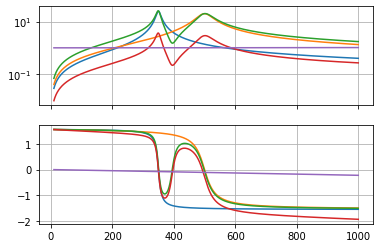

In [263]:
fig,ax=plt.subplots(2,sharex=True)
frange=np.linspace(10,1000,1000)
wrange=2*np.pi*frange
bodeplot(frange,zbore(1j*wrange),ax=ax)
bodeplot(frange,zvt(1j*wrange),ax=ax)
bodeplot(frange,zbore(1j*wrange)+zvt(1j*wrange),ax=ax)
#bodeplot(frange,zcomb(1j*wrange),ax=ax)
#bodeplot(frange,zcomb(1j*wrange),ax=ax)
bodeplot(frange,eqc(1j*wrange),ax=ax)
bodeplot(frange,zkreed(1j*wrange),ax=ax)
for axi in ax:
    axi.grid(True)


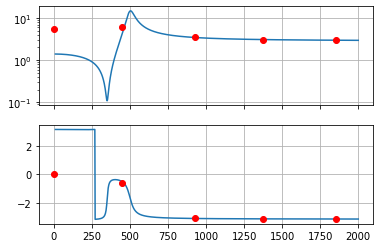

In [266]:
fig,ax=plt.subplots(2,sharex=True)
frange=np.linspace(10,2000,1000)
wrange=2*np.pi*frange
bodeplot(frange,-zvt(1j*wrange)/zbore(1j*wrange),ax=ax)
for axi in ax:
    axi.grid(True)
for tsv,tsb in zip(hetpv,hetpb):
    tts=(tsv/tsb).apply(np.abs)
    tts.label=tsv.label
    ax[0].plot(tsv.f,tts.percentile(50,from_time=res['t_trans_end']),'or')

    tts=(tsv/tsb).apply(lambda x:np.flipud(np.unwrap(np.angle(np.flipud(x)))))
    tts.label=tsv.label
    ax[1].plot(tsv.f,-np.mod(tts.percentile(50,from_time=res['t_trans_end'])-np.pi,2*np.pi)+np.pi,'or')


In [34]:
tts.percentile(50,from_time=res['t_trans_end'])

3.1389647534760745

## Checking resonance parameters

### Bore

In [369]:
mod = cs.acmode[0]
mod.a*mod.w/mod.q

2199.114857512855

In [370]:
omega_b=2*pi*jso['bore/frequencies/0']
q_b=jso['bore/qs/0']
a_b=jso['bore/amplitudes/0']
print('numerator  :', [a_b*omega_b/q_b,0])
print('denominator:', [1, omega_b/q_b, omega_b**2])

numerator  : [2199.114857512855, 0]
denominator: [1, 87.9645943005142, 4836106.156533784]


In [376]:
print('numerator  :', polyadd(polymul([mod.c.conj()],[1,mod.s.conj()]),polymul([mod.c],[1,mod.s])))
print('denominator:', (polymul([1,mod.s.conj()],[1,mod.s])))

numerator  : [   2199.11485751+0.j -193444.24626135+0.j]
denominator: [ 1.00000000e+00+0.j -8.79645943e+01+0.j  4.83610616e+06+0.j]


In [388]:
r,p,k=sig.residue([a_b*omega_b/q_b,0],[1, omega_b/q_b, omega_b**2])
print(r,p)

[1099.55742876+21.99554812j 1099.55742876-21.99554812j] [-43.98229715+2198.67499055j -43.98229715-2198.67499055j]


In [386]:
polyadd(polymul([r[0].conj()],[1,p[0].conj()]),polymul([r[0]],[1,p[0]]))

array([   2199.11485751+0.j, -193444.24626135+0.j])

In [387]:
mod.__dict__

{'f': 350,
 'q': 25,
 'a': 25,
 'w': 2199.114857512855,
 'w2': 4836106.156533784,
 's': (-43.982297150257104+2198.6749905502566j),
 'c': (1099.5574287564275+21.99554812475247j),
 'pc': 0,
 'p0': 0.00020004001200400143j}

### Vocal tract

In [39]:
mod = cs.vtmode[0]
mod.a*mod.w/mod.q

3141.592653589793

In [40]:
polyadd(polymul([mod.c.conj()],[1,mod.s.conj()]),polymul([mod.c],[1,mod.s]))

array([ 3.14159265e+03+0.j, -5.82076609e-11+0.j])

### Reed

In [41]:
omega_reed=2*pi*jso['reed/frequency']
q_reed=jso['reed/q']
a_reed=jso['reed/amplitude']

a_reed*omega_reed**2/q_reed

835363316.5082031

In [42]:
polyadd(polymul([cs.cr.conj()],[1,cs.sr.conj()]),polymul([cs.cr],[1,cs.sr]))

array([0.00000000e+00+0.j, 8.35363317e+08+0.j])

In [43]:
cs.nlfunc

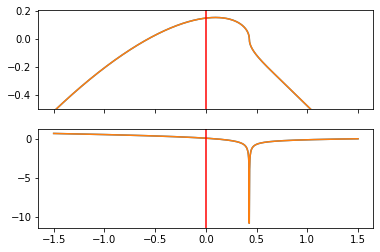

In [44]:
fig,ax=plt.subplots(2,sharex=True)
p=np.linspace(-1.5,1.5,1000)
u=zeta*(1-gamma+p)*np.sqrt(np.abs(gamma-p))*np.sign(gamma-p)
du = zeta*np.sqrt(np.abs(gamma-p))-zeta/2*(1-gamma+p)/np.sqrt(np.abs(gamma-p))

ax[0].plot(p,u)
alpha=.001
ur=zeta*(1-gamma+p)*(np.sqrt(np.abs(gamma-p)+alpha**2)-alpha)*np.sign(gamma-p)
dur = zeta*(np.sqrt(np.abs(gamma-p)+alpha**2)-alpha)-zeta/2*(1-gamma+p)/np.sqrt(np.abs(gamma-p+alpha**2))
ax[0].plot(p,ur)

ax[0].axvline(0,color='r')
ax[0].set_ylim(-.5,None)
ax[1].plot(p,du)
ax[1].plot(p,dur)
ax[1].axvline(0,color='r')


In [45]:
print(json.dumps(row.to_python(),indent=2,default=str))

{
  "_id": "5f96b5d598b40108a64ecaec",
  "simulation": {
    "start": "2020-10-26 22:40:48.697000",
    "params": {
      "description": "Reed simulation with modal tracts and reed dynamics and non-linear reed force var gamma",
      "version": "20201026",
      "db": "modal-vt-bore-jumps-2",
      "tmax": 0.5,
      "gamma": {
        "sustain_val": 0.6806386377728367,
        "time_const": 0.05,
        "exp_limit_multiplier": 1.1
      },
      "zeta": 0.5,
      "reed": {
        "frequency": 2572.670484740299,
        "q": 4.541154354079546,
        "amplitude": 4.541154354079546
      },
      "bore": {
        "frequencies": [
          665.4425938172074
        ],
        "qs": [
          18.007751052384776
        ],
        "amplitudes": [
          18.007751052384776
        ]
      },
      "vocal": {
        "frequencies": [
          500
        ],
        "qs": [
          15
        ],
        "amplitudes": [
          15
        ]
      },
      "nlfunc": {
        "t

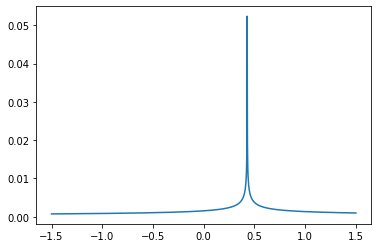

In [46]:
plot(p,(u-ur)/u)

In [47]:
fsolve?

Signature:
fsolve(
    func,
    x0,
    args=(),
    fprime=None,
    full_output=0,
    col_deriv=0,
    xtol=1.49012e-08,
    maxfev=0,
    band=None,
    epsfcn=None,
    factor=100,
    diag=None,
)
Docstring:
Find the roots of a function.

Return the roots of the (non-linear) equations defined by
``func(x) = 0`` given a starting estimate.

Parameters
----------
func : callable ``f(x, *args)``
    A function that takes at least one (possibly vector) argument,
    and returns a value of the same length.
x0 : ndarray
    The starting estimate for the roots of ``func(x) = 0``.
args : tuple, optional
    Any extra arguments to `func`.
fprime : callable ``f(x, *args)``, optional
    A function to compute the Jacobian of `func` with derivatives
    across the rows. By default, the Jacobian will be estimated.
full_output : bool, optional
    If True, return optional outputs.
col_deriv : bool, optional
    Specify whether the Jacobian function computes derivatives down
    the columns (fa